# Common import and setup


In [14]:
import os, sys, time, pytest

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import pdfminer

from IPython.display import display

# Make sure we use the local version of camelot if it is here
sys.path.insert(0, os.path.abspath(''))

import camelot
from camelot.core import Table, TableList, TextEdges
from camelot.__version__ import generate_version
from camelot.utils import get_text_objects, text_in_bbox
from camelot.parsers.stream import Stream
from camelot.parsers.hybrid import Hybrid
from camelot.handlers import PDFHandler
from camelot.plotting import draw_pdf
from tests.data import *

testdir = os.path.dirname(os.path.abspath('.'))
testdir = os.path.join(testdir, "camelot/tests/files")

# To check which library we're using
camelot.__file__


'/Users/francoishuet/Code/camelot/camelot/__init__.py'

In [15]:
kwargs = {}
data = None
# pdf_file = "vertical_header.pdf"
# pdf_file, kwargs, data = "superscript.pdf", {"flag_size": True}, data_stream_flag_size # test_hybrid_flag_size
# pdf_file = "health.pdf"  # test_hybrid
# pdf_file = "clockwise_table_2.pdf"
# pdf_file = "tabula/12s0324.pdf" # interesting because contains two separate tables
# pdf_file, kwargs = "tabula/us-007.pdf", {"table_regions": ["320,335,573,505"]} # test_hybrid_table_regions
pdf_file, kwargs = "detect_vertical_false.pdf", {"strip_text": " ,\n"}  # data_stream_strip_text
# pdf_file, kwargs, data = "tabula/m27.pdf", {"columns": ["72,95,209,327,442,529,566,606,683"], "split_text": True, }, data_stream_split_text  # data_stream_split_text
# pdf_file = "vertical_header.pdf"
# pdf_file = "twotables_2.pdf"
# pdf_file = "camelot-issue-132-multiple-tables.pdf"
# pdf_file, kwargs, data = "edge_tol.pdf", {"edge_tol": 500}, data_stream_edge_tol
# pdf_file, kwargs, data = "edge_tol.pdf", {}, data_stream_edge_tol

filename = os.path.join(testdir, pdf_file)

Showing first table found by stream:


,0,1
0,VinsauVerre,
1,LesBlancs,12.5CL
2,A.O.PCôtesduRhône,
3,DomainedelaGuicharde«Autourdelachapelle»2016,8€
4,A.O.PVacqueyras,
5,DomainedeMontvac«Melodine»2016,10€
6,A.O.PChâteauneufduPape,
7,DomainedeBeaurenard2017,13€
8,A.O.PCôteauxduLanguedoc,
9,VillaTempora«Untempspourelle»2014,9€


Showing first table found by hybrid:


,0,1
0,VinsauVerre,
1,LesBlancs,12.5CL
2,A.O.PCôtesduRhône,
3,DomainedelaGuicharde«Autourdelachapelle»2016,8€
4,A.O.PVacqueyras,
5,DomainedeMontvac«Melodine»2016,10€
6,A.O.PChâteauneufduPape,
7,DomainedeBeaurenard2017,13€
8,A.O.PCôteauxduLanguedoc,
9,VillaTempora«Untempspourelle»2014,9€


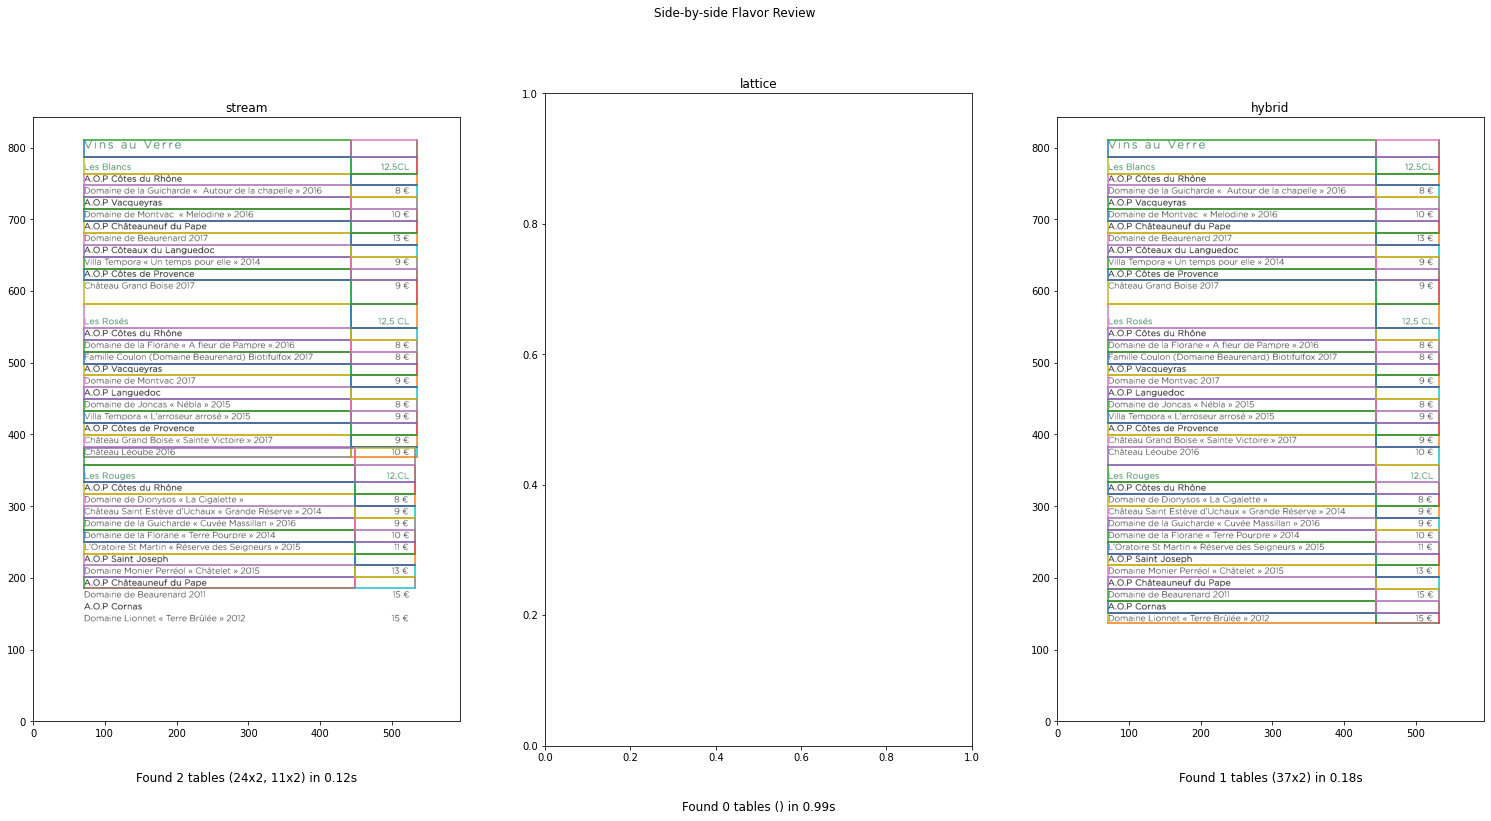

In [20]:

# Set up plots to be large enough for visualization
plt.rcParams["figure.figsize"] = [26, 12]
fig, axes = plt.subplots(1, 3)
fig.suptitle('Side-by-side Flavor Review')
tables_list = []
for idx, flavor in enumerate(["stream", "lattice", "hybrid"]):
    timer_before_parse = time.perf_counter()
    tables = camelot.read_pdf(filename, flavor=flavor, debug=True, **kwargs)
    tables_list.append(tables)
    timer_after_parse = time.perf_counter()
    ax = axes[idx]
    if len(tables):
        print(f"Showing first table found by {flavor}:")
        display(tables[0].df)
    for table in tables:
        fig = camelot.plot(table, kind='grid', ax=ax)
    ax.set_title("{flavor}".format(flavor=flavor))
    tables_dims = ", ".join(
        map(
            lambda table: "{rows}x{cols}".format(
                rows=table.shape[0],
                cols=table.shape[1],
            ), tables
        )
    )
    ax.text(
        0.5,-0.1, 
        "Found {table_num} tables ({tables_dims}) in {parse_time:.2f}s".format(
            table_num=len(tables),
            tables_dims=tables_dims,
            parse_time=timer_after_parse - timer_before_parse,
        ), 
        size=12, ha="center", 
        transform=ax.transAxes
    )
    timer_after_plot = time.perf_counter()
fig